In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lxml

In [30]:
%%capture
%env http_proxy=http://entproxy.kdc.capitalone.com:8099
%env https_proxy=http://entproxy.kdc.capitalone.com:8099

### Source: Labor Condition Application (LCA) data 
from the Department of Labor (DOL)

- Original Article: https://towardsdatascience.com/how-much-do-data-scientists-make-cbd7ec2b458
- Data source for this project: https://h1bdata.info/index.php
- Original data source: https://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis

In [33]:
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+JOSE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+CLARA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SUNNYVALE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MOUNTAIN+VIEW&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=CUPERTINO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MENLO+PARK&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=PALO+ALTO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDWOOD+CITY&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+MATEO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+FRANCISCO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SEATTLE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDMOND&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+MONICA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=LOS+ANGELES&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=AUSTIN&year=All+Years',
         'https://h1bdata.info/index.php?em=amazon&job=Data+Scientist+I&city=&year=All+Years'
       ]


Extract all the data with no filter:

In [44]:
# link to the entire db 
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=&year=2019',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=&year=2018'
        ]

In [45]:
# Scrape table data from each of the above links and store in a list

jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, 'lxml')

    for row in page_content.find_all('tr')[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

ProxyError: HTTPSConnectionPool(host='h1bdata.info', port=443): Max retries exceeded with url: /index.php?em=&job=Data+Scientist&city=&year=2019 (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 407 Proxy Authentication Required')))

In [35]:
len(jobs_list)

3192

In [15]:
jobs_list[0:5]

[['VALIANTICA INC',
  'DATA SCIENTIST',
  '101,740',
  'SAN JOSE, CA',
  '03/20/2019',
  '09/16/2019',
  'CERTIFIED'],
 ['BRANCH MESSENGER INC',
  'DATA SCIENTIST',
  '117,500',
  'SAN JOSE, CA',
  '03/06/2018',
  '09/04/2018',
  'CERTIFIED'],
 ['THREATMETRIX INC',
  'DATA SCIENTIST',
  '5,769',
  'SAN JOSE, CA',
  '01/06/2015',
  '01/26/2015',
  'CERTIFIED'],
 ['VIRTUAL ENTERPRISE SYSTEM SOLUTIONS INC',
  'DATA SCIENTIST',
  '51,355',
  'SAN JOSE, CA',
  '03/19/2019',
  '09/13/2019',
  'CERTIFIED'],
 ['PEOPLEAXIS INC',
  'DATA SCIENTIST',
  '66,518',
  'SAN JOSE, CA',
  '03/16/2017',
  '08/20/2017',
  'CERTIFIED']]

In [16]:
# Put everything into dataframes for easier processing

ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]

ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)

ds_jobs_df['location'] = [i[3] for i in jobs_list]

ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

In [17]:
ds_jobs_df.shape

(332, 6)

In [18]:
ds_jobs_df.head()

,company,title,salary,location,date,year
0,VALIANTICA INC,DATA SCIENTIST,101740.0,"SAN JOSE, CA",2019-03-20,2019
1,BRANCH MESSENGER INC,DATA SCIENTIST,117500.0,"SAN JOSE, CA",2018-03-06,2018
2,THREATMETRIX INC,DATA SCIENTIST,5769.0,"SAN JOSE, CA",2015-01-06,2015
3,VIRTUAL ENTERPRISE SYSTEM SOLUTIONS INC,DATA SCIENTIST,51355.0,"SAN JOSE, CA",2019-03-19,2019
4,PEOPLEAXIS INC,DATA SCIENTIST,66518.0,"SAN JOSE, CA",2017-03-16,2017


In [19]:
# outliners

# Drop pre 2014 data (very few observations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<2014].index, axis=0, inplace=True)

# Drop salaries over $1,000,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>1000000].index, axis=0, inplace=True)

# Sort by company and year
ds_jobs_df.sort_values(by=['year','company'], inplace=True, ascending=True)

In [20]:
ds_jobs_df.shape

(332, 6)

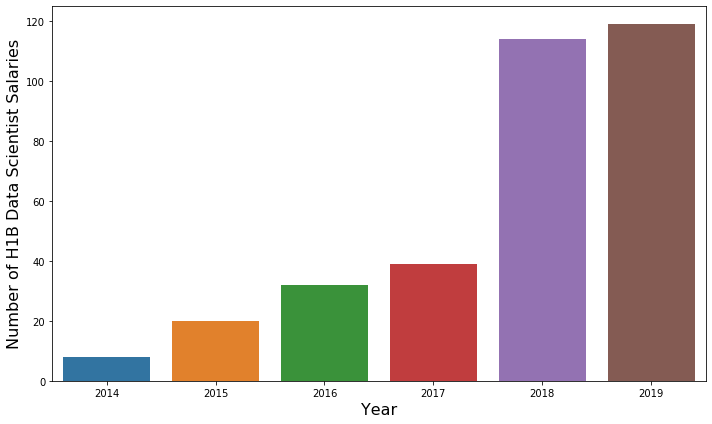

In [21]:

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=ds_jobs_df['year'].value_counts().sort_index().index, 
                 y=ds_jobs_df['year'].value_counts().sort_index().values)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Number of H1B Data Scientist Salaries",fontsize=16)
plt.tight_layout()
plt.savefig(fname='num_jobs', dpi=150)

In [22]:
ds_jobs_df['salary'].median()

120000.0

In [26]:
median_salary = ds_jobs_df.groupby(by=['year']).median().reset_index()
median_salary

,year,salary
0,2014,120000.0
1,2015,117846.5
2,2016,120000.0
3,2017,120000.0
4,2018,120000.0
5,2019,110004.0


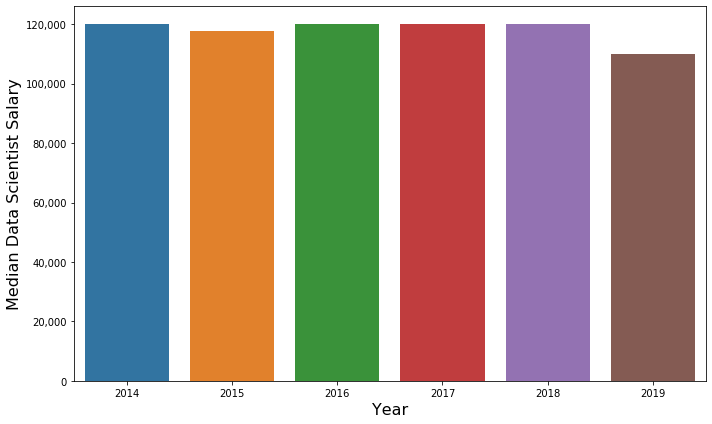

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=median_salary['year'], 
                 y=median_salary['salary'])
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Median Data Scientist Salary",fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(fname='median_salary', dpi=150)